# Машинное обучение, ФКН ВШЭ

## Практическое задание 5. Решающие деревья

### Общая информация
Дата выдачи: 29.11.2023

Мягий дедлайн: 23:59 12.12.2023

Жестокий дедлайн: 23:59 14.12.2023

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплиментацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-05-trees-Username.ipynb
* Модуль hw5code.py
* Ссылки на посылки в Яндекс.Контесте для обеих задач

В контест https://contest.yandex.ru/contest/56884/problems/ нужно отправить файл hw5code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже:

__Оценка:__ 11 баллов (сделал все, включая бонус, и использую свою последнюю просрочку без штрафа)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0., )
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

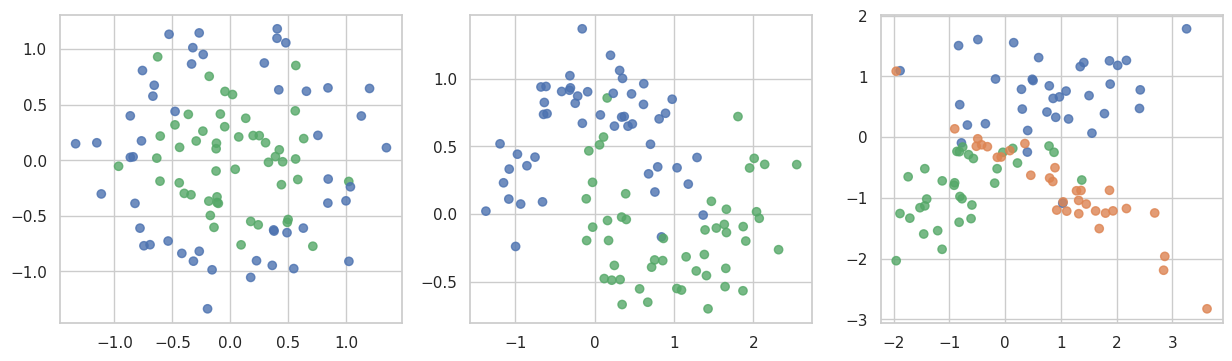

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [5]:
def plot_surface(clf, X, y, max_depth=None, min_samples_leaf=None, row=None, col=None, ind=None):
    if row is not None and col is not None:
      plt.figure(figsize = (32, 16))
      plt.subplot(row, col, ind)
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    if max_depth is not None and min_samples_leaf is not None:
      plt.title("max_depth: " + str(max_depth) + "; min_samples_leaf: " + str(min_samples_leaf))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

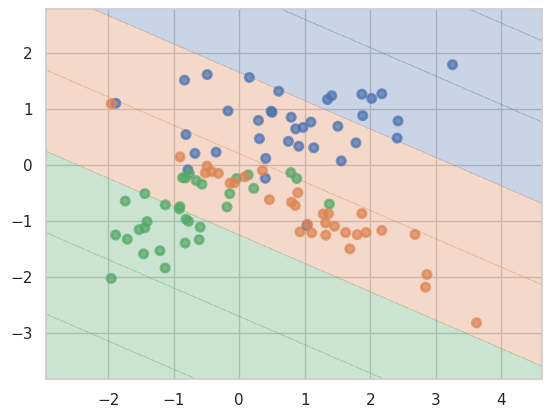

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

accuracy:  0.7


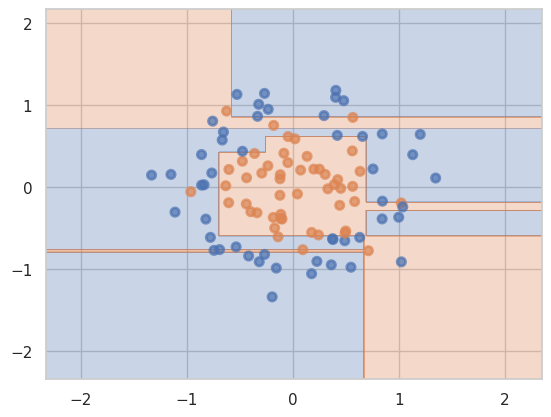

In [7]:
from sklearn.metrics import accuracy_score

def plot_surface_for_decision_tree(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  clf = DecisionTreeClassifier()
  clf.fit(X_train, y_train)
  plot_surface(clf, X, y)
  print("accuracy: ", accuracy_score(y_test, clf.predict(X_test)))

X, y = datasets[0]
plot_surface_for_decision_tree(X, y)

accuracy:  0.95


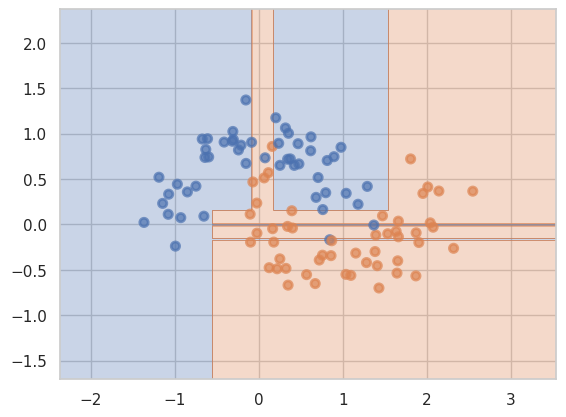

In [8]:
X, y = datasets[1]
plot_surface_for_decision_tree(X, y)

accuracy:  0.7


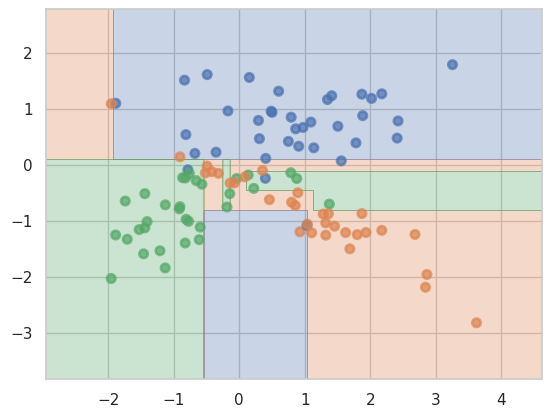

In [9]:
X, y = datasets[2]
plot_surface_for_decision_tree(X, y)

__Ответ:__ области получились довольно сложные, их много, причем иногда эти области какие то уж слишком специфичные, как например несколько тонких полосок на втором графике. Короче наблюдаем явное переобучение.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

,train accuracy,test accuracy
max_depth: 3; min_samples_leaf: 3,0.8625,0.75
max_depth: 3; min_samples_leaf: 2,0.8625,0.75
max_depth: 3; min_samples_leaf: 1,0.875,0.7
max_depth: 4; min_samples_leaf: 3,0.925,0.75
max_depth: 4; min_samples_leaf: 2,0.9375,0.8
max_depth: 4; min_samples_leaf: 1,0.9625,0.7
max_depth: 5; min_samples_leaf: 3,0.9375,0.7
max_depth: 5; min_samples_leaf: 2,0.9375,0.8
max_depth: 5; min_samples_leaf: 1,0.975,0.75
max_depth: 6; min_samples_leaf: 3,0.9375,0.7


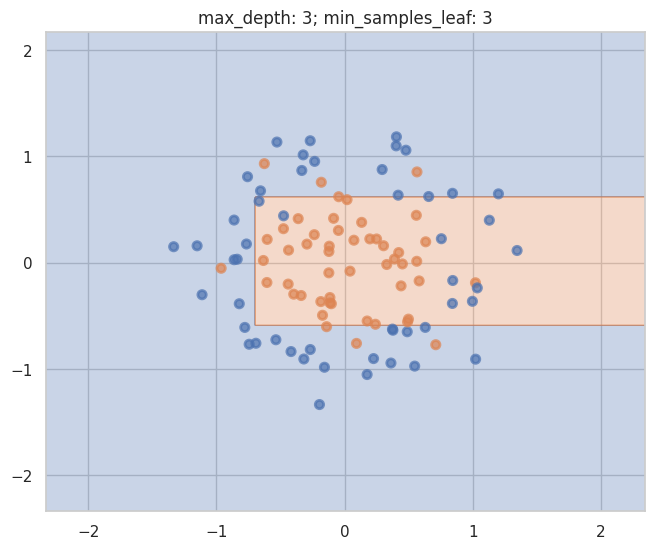

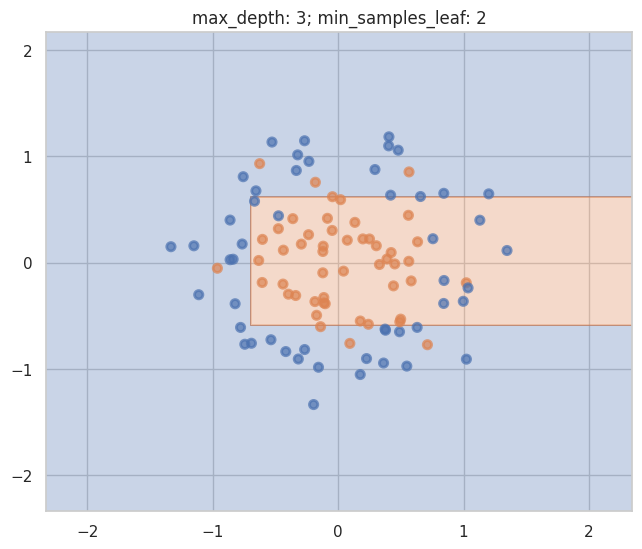

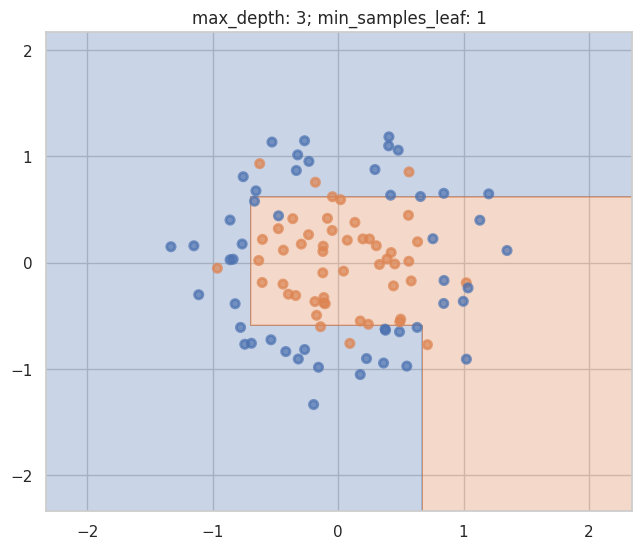

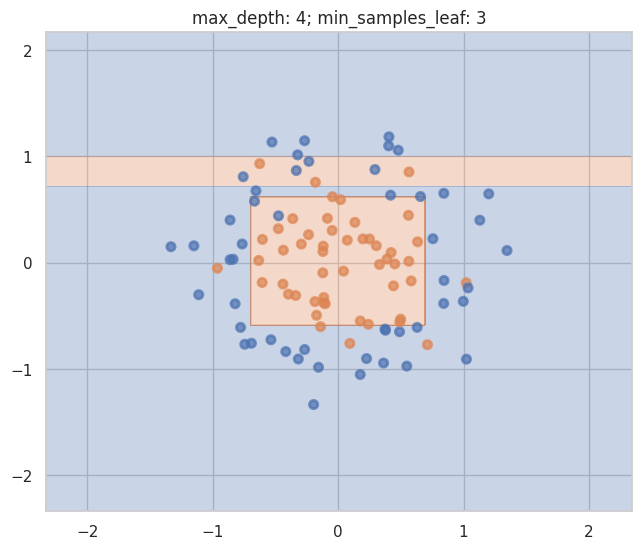

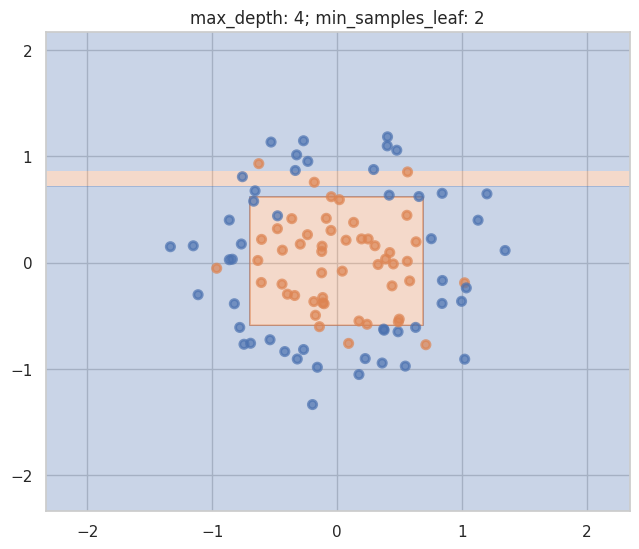

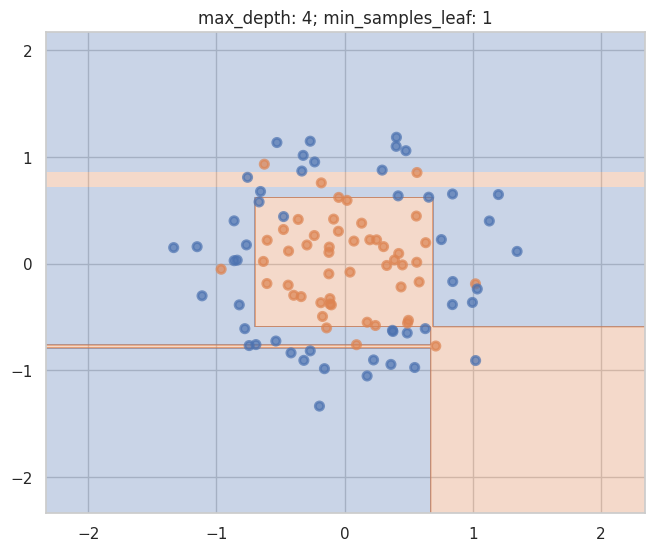

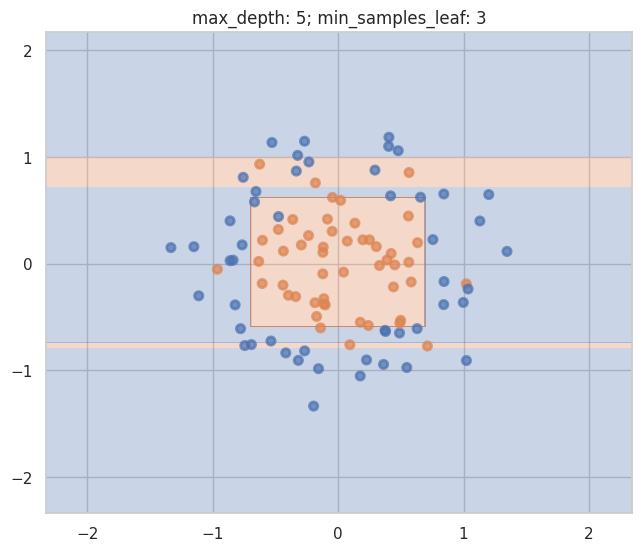

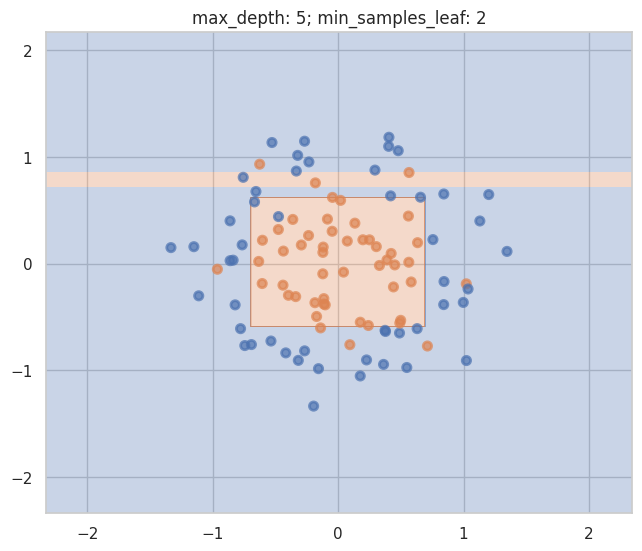

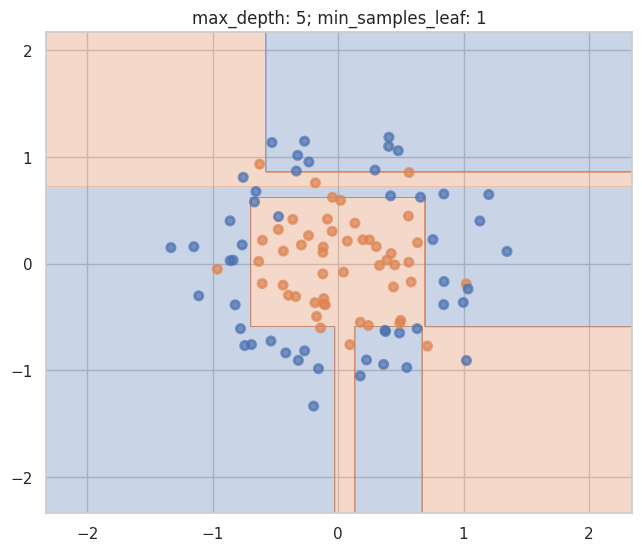

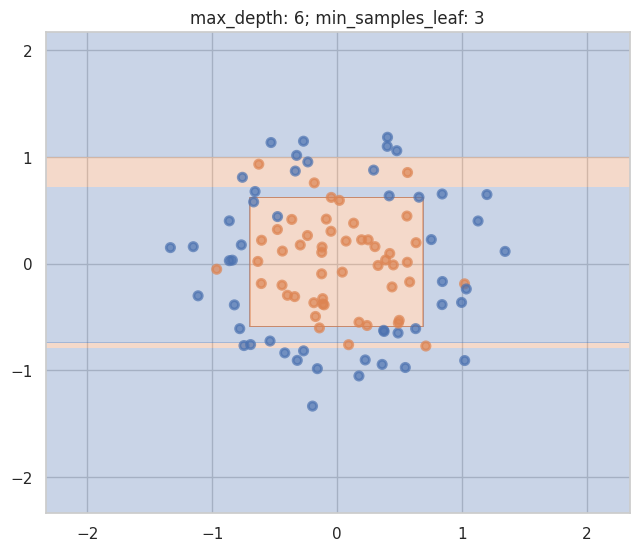

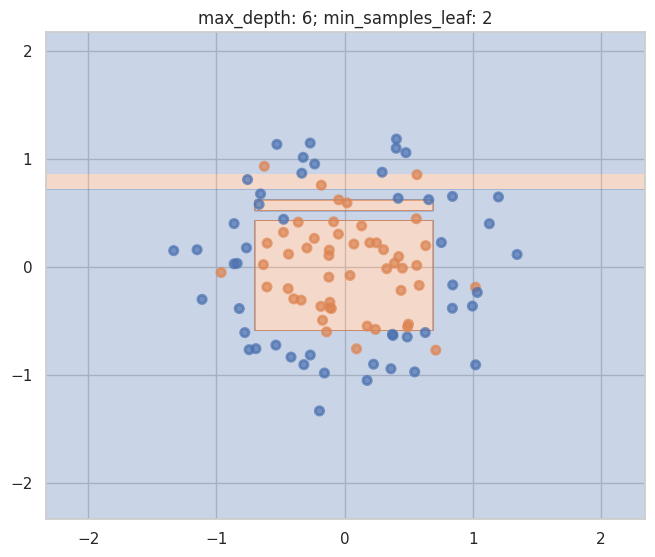

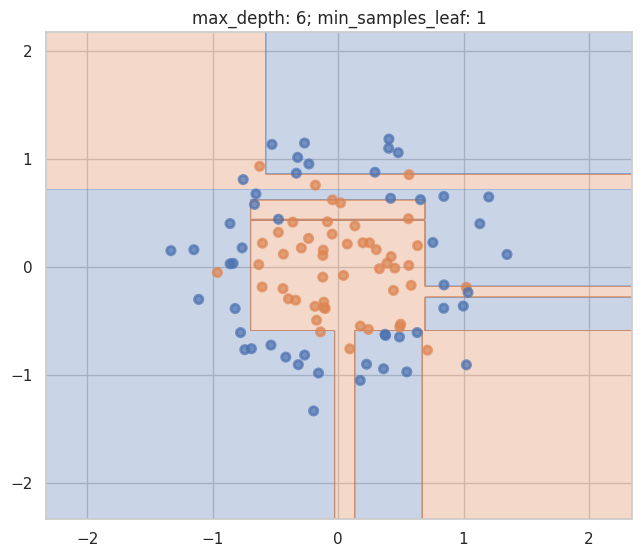

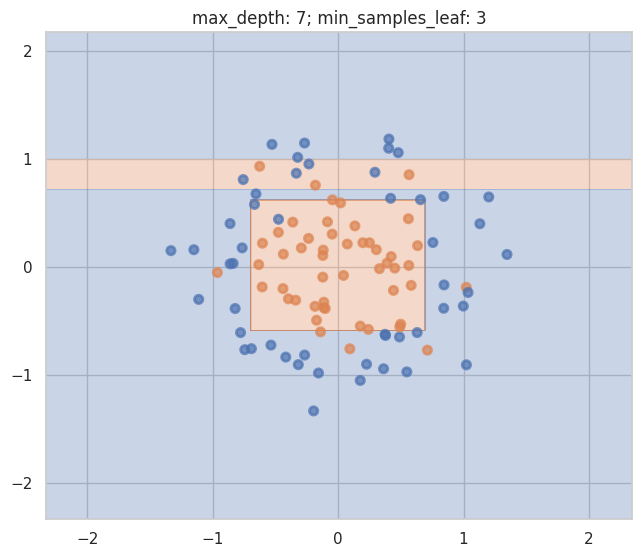

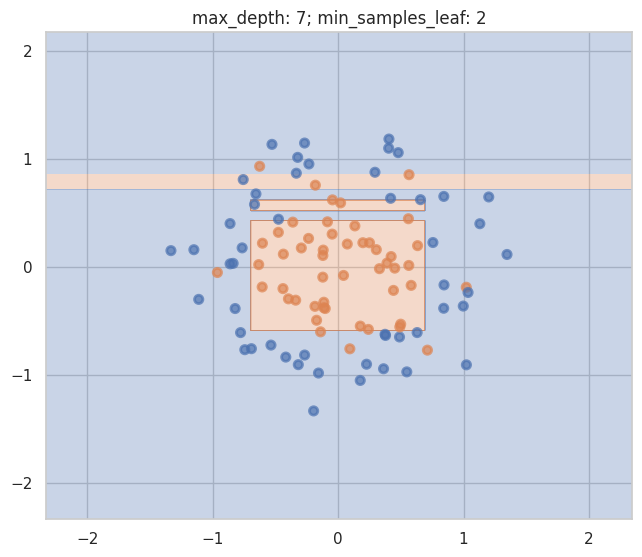

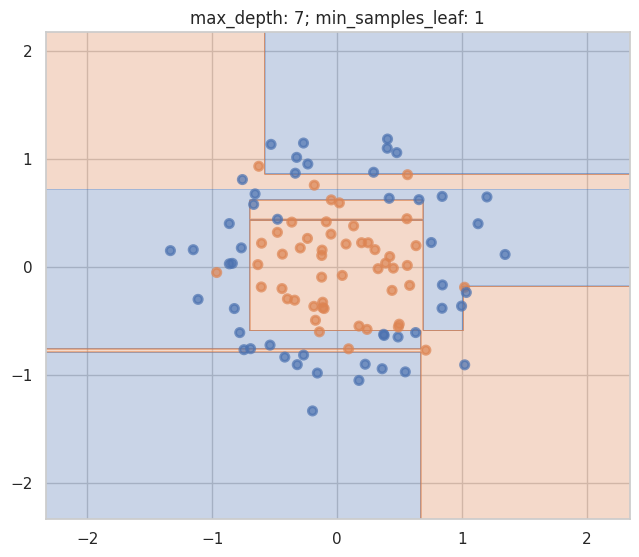

In [10]:
# ну раз от нас просят каждый раз одинаковое разбиение, то давайте разобьем все в начале
X, y = datasets[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def boo():
  global X
  global y
  global X_train
  global X_test
  global y_train
  global y_test


  ind = 1
  table = pd.DataFrame(columns=['train accuracy', 'test accuracy'])
  for max_depth in range(3, 8):
    for min_samples_leaf in range(3, 0, -1):
      clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
      clf.fit(X_train, y_train)
      table.loc['max_depth: ' + str(max_depth) + '; min_samples_leaf: ' + str(min_samples_leaf), :] = [accuracy_score(y_train, clf.predict(X_train)), accuracy_score(y_test, clf.predict(X_test))]
      plot_surface(clf, X, y, max_depth, min_samples_leaf, row=3, col=5, ind=ind)
      ind += 1
  return table

boo()

,train accuracy,test accuracy
max_depth: 3; min_samples_leaf: 3,0.9,1.0
max_depth: 3; min_samples_leaf: 2,0.9125,1.0
max_depth: 3; min_samples_leaf: 1,0.9125,1.0
max_depth: 4; min_samples_leaf: 3,0.9625,0.95
max_depth: 4; min_samples_leaf: 2,0.975,0.95
max_depth: 4; min_samples_leaf: 1,0.9875,0.95
max_depth: 5; min_samples_leaf: 3,0.9625,0.95
max_depth: 5; min_samples_leaf: 2,0.975,0.95
max_depth: 5; min_samples_leaf: 1,0.9875,0.95
max_depth: 6; min_samples_leaf: 3,0.9625,0.95


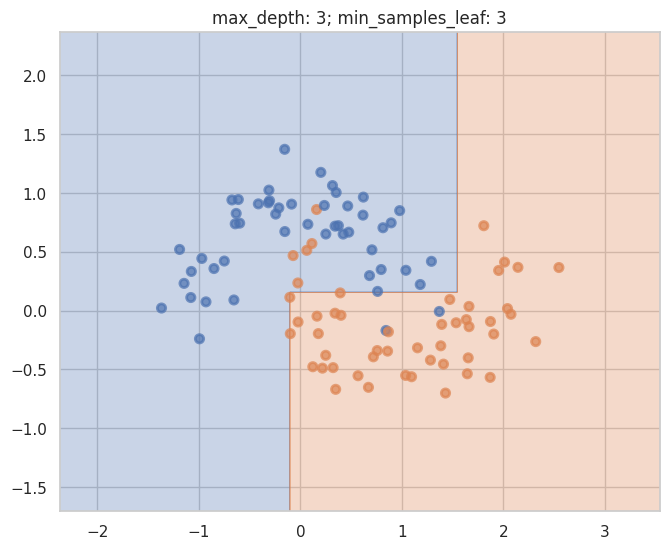

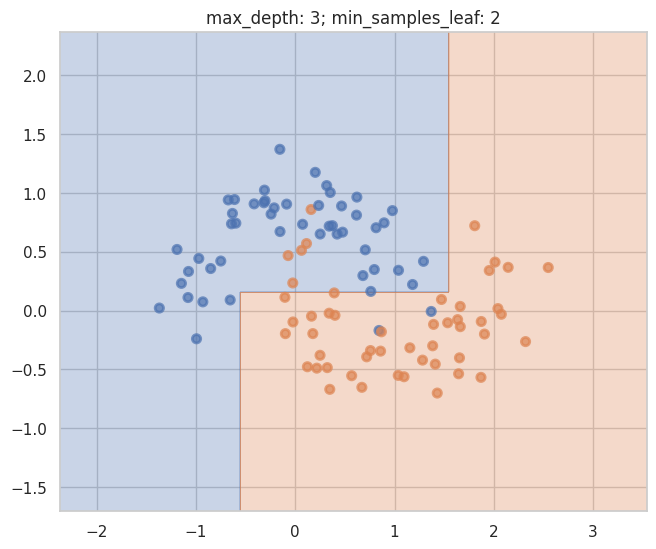

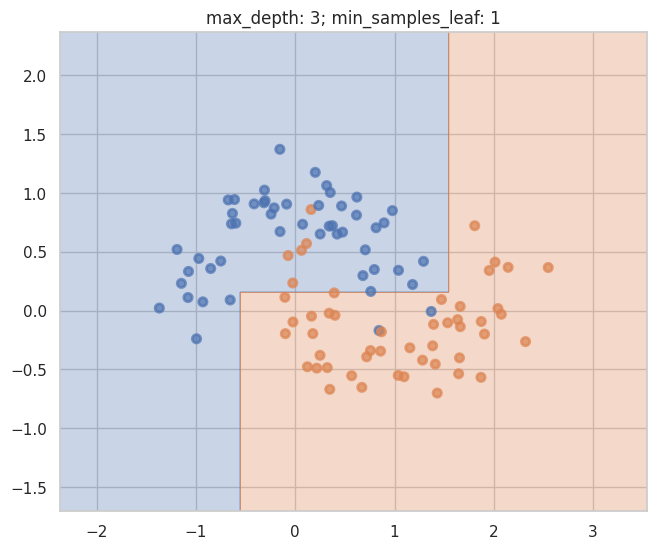

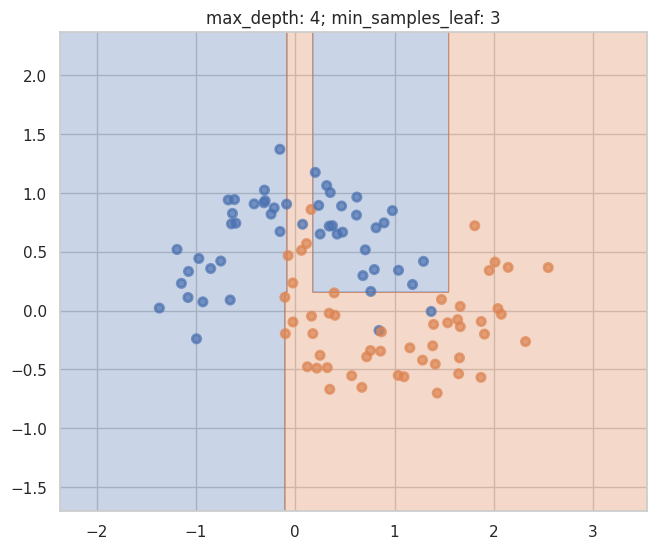

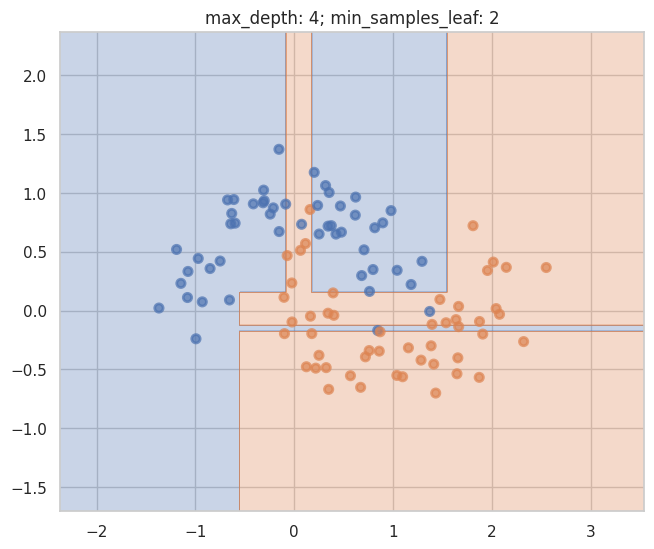

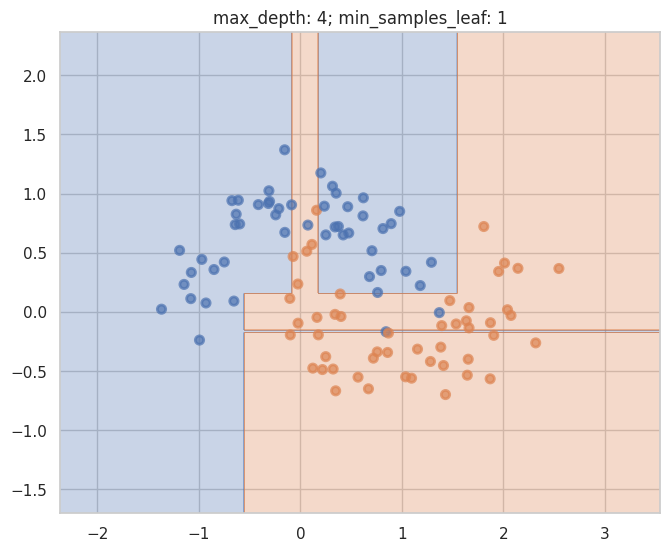

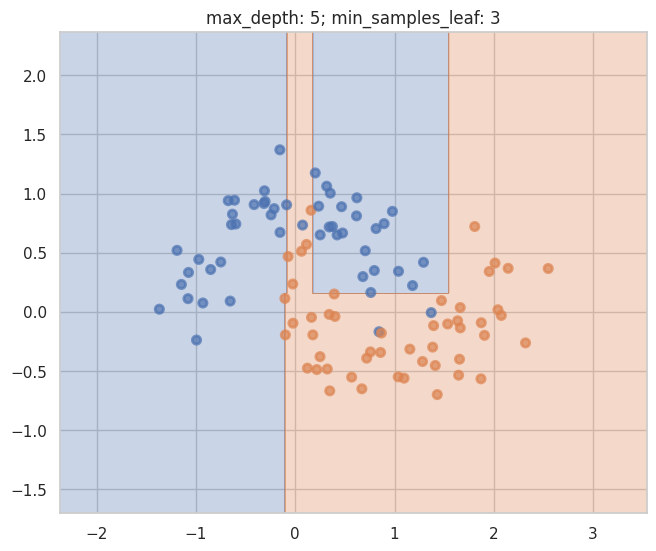

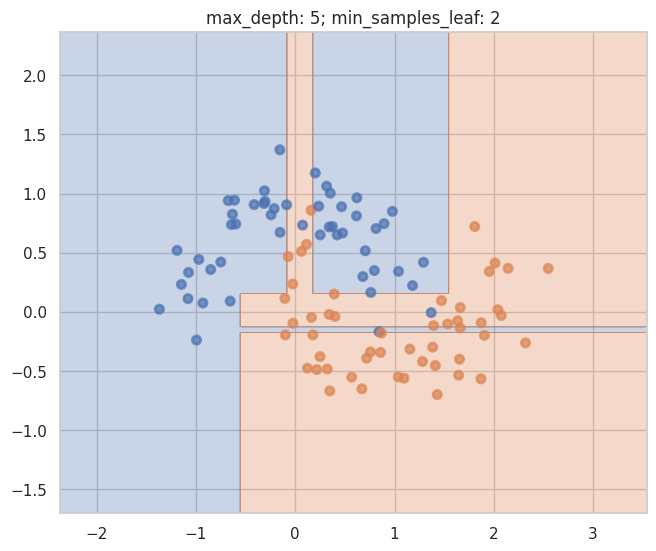

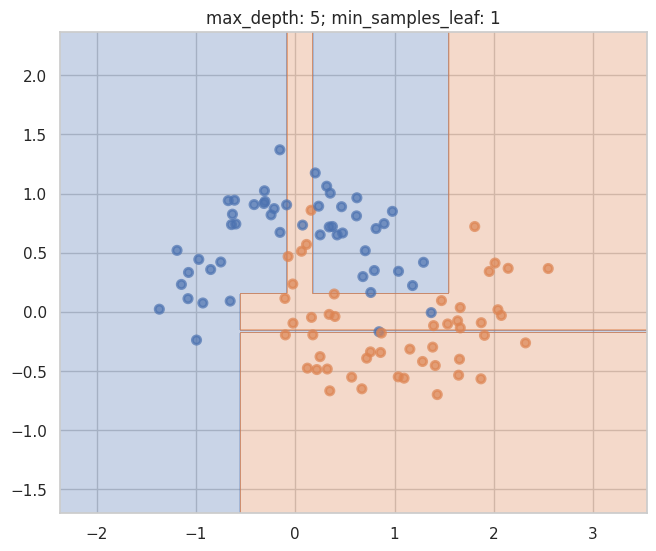

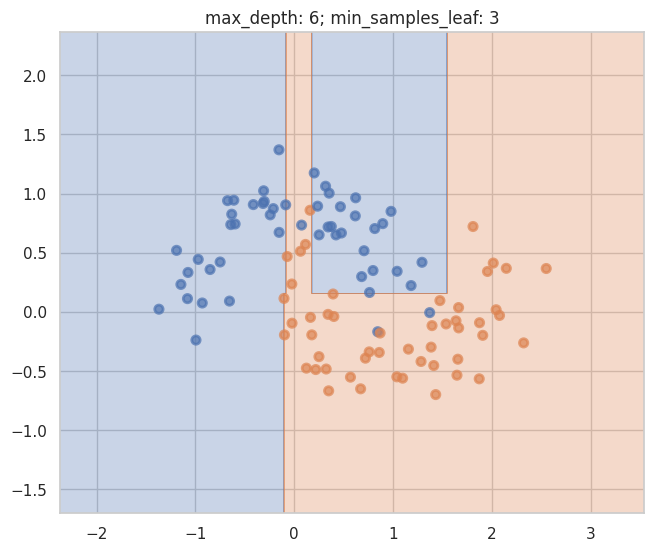

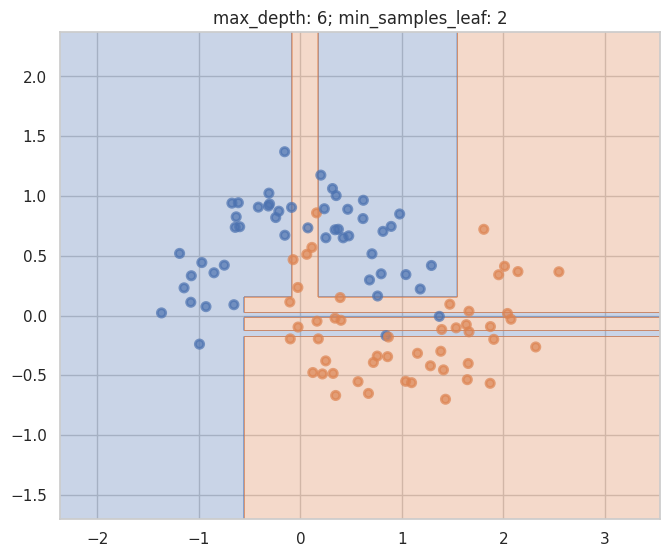

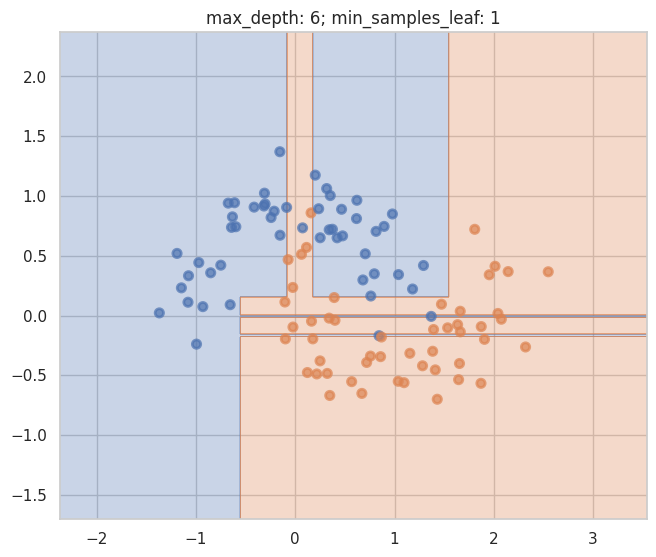

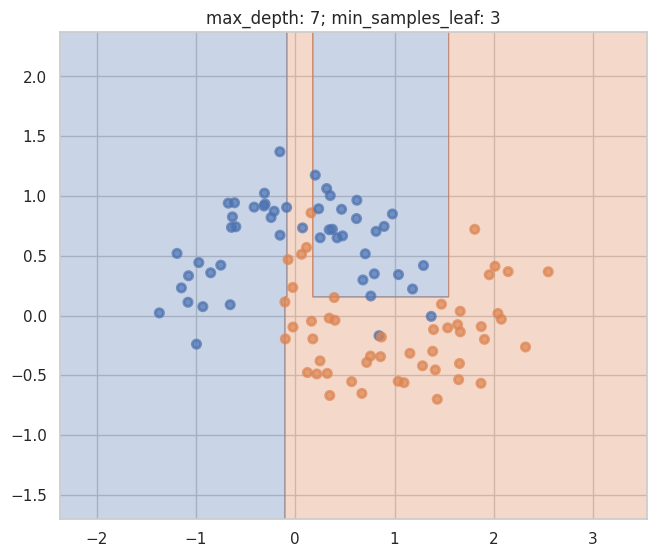

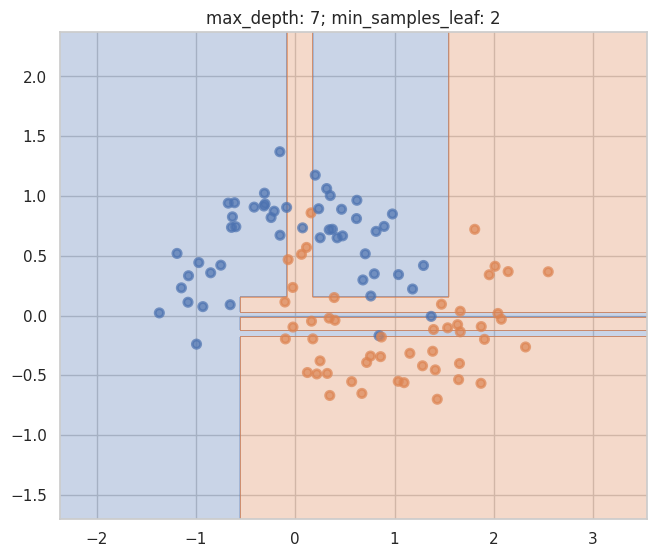

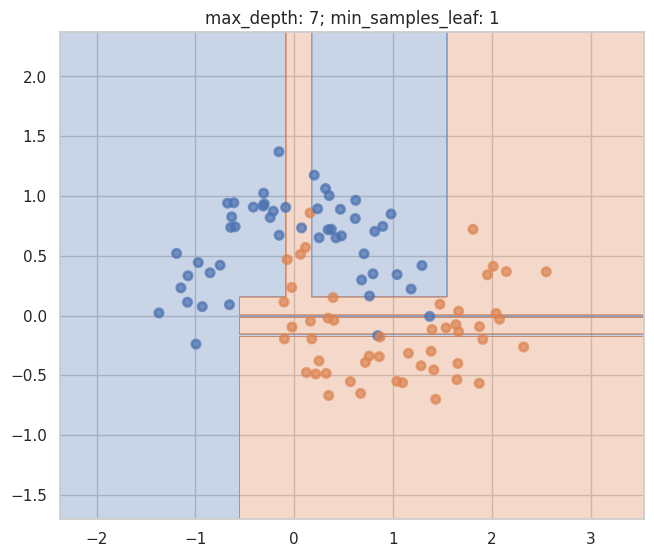

In [11]:
X, y = datasets[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
boo()

,train accuracy,test accuracy
max_depth: 3; min_samples_leaf: 3,0.8875,0.75
max_depth: 3; min_samples_leaf: 2,0.8875,0.75
max_depth: 3; min_samples_leaf: 1,0.9,0.75
max_depth: 4; min_samples_leaf: 3,0.8875,0.75
max_depth: 4; min_samples_leaf: 2,0.8875,0.7
max_depth: 4; min_samples_leaf: 1,0.9125,0.7
max_depth: 5; min_samples_leaf: 3,0.9,0.7
max_depth: 5; min_samples_leaf: 2,0.9125,0.7
max_depth: 5; min_samples_leaf: 1,0.9375,0.7
max_depth: 6; min_samples_leaf: 3,0.9125,0.7


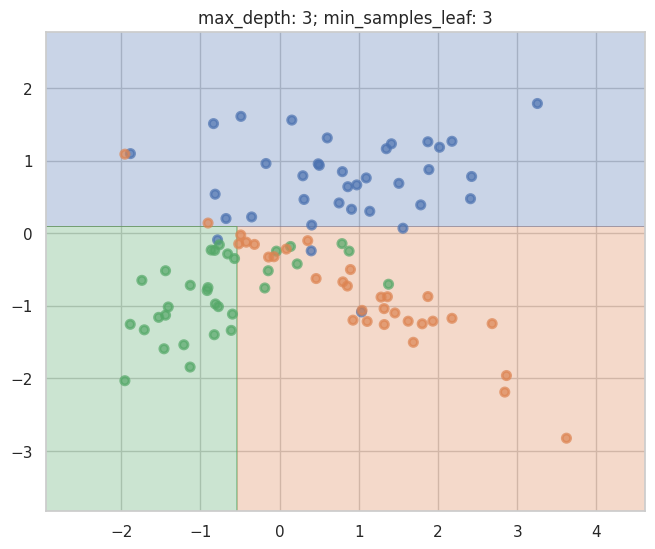

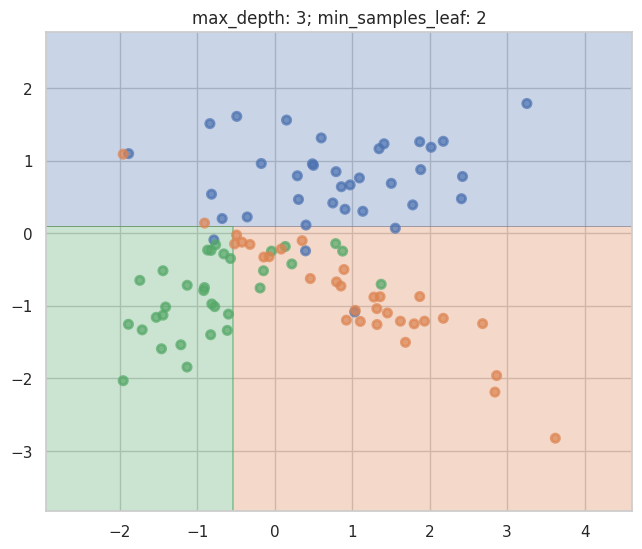

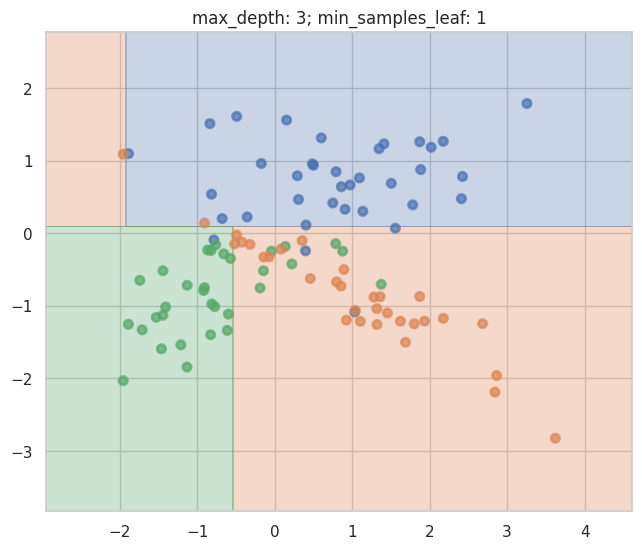

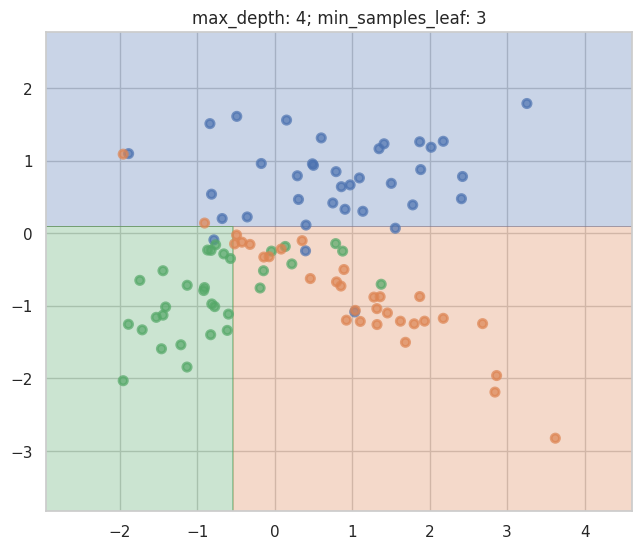

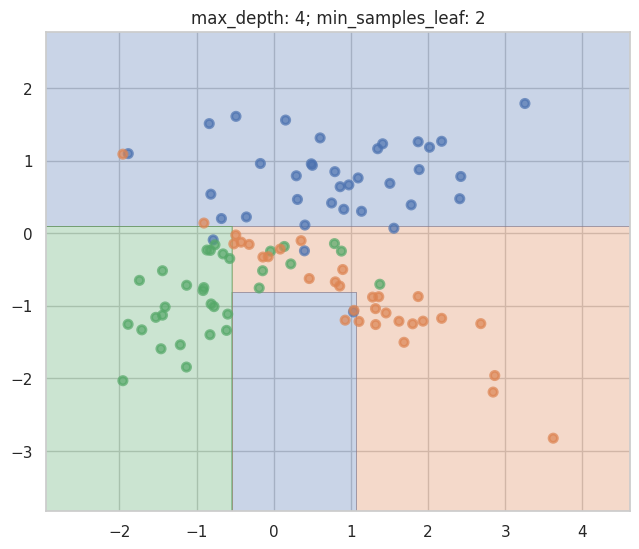

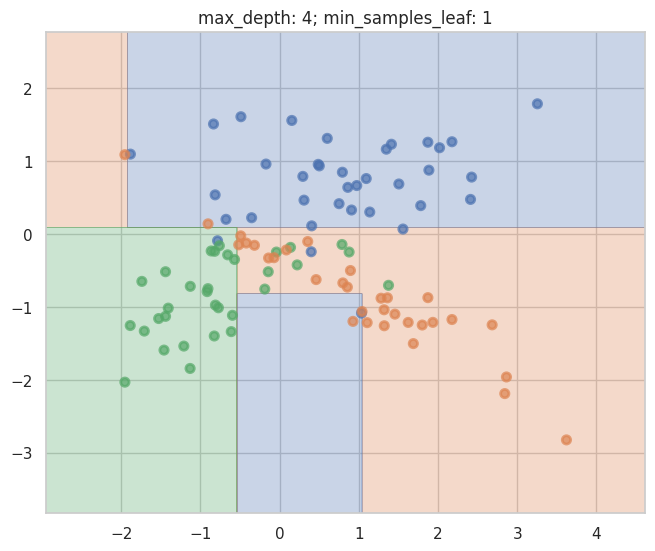

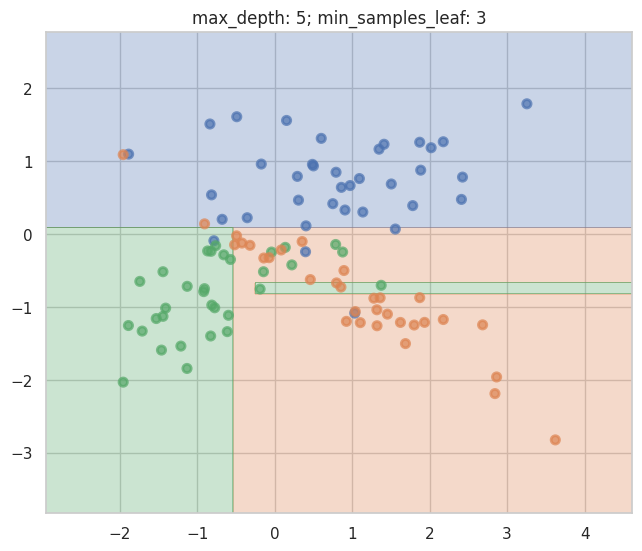

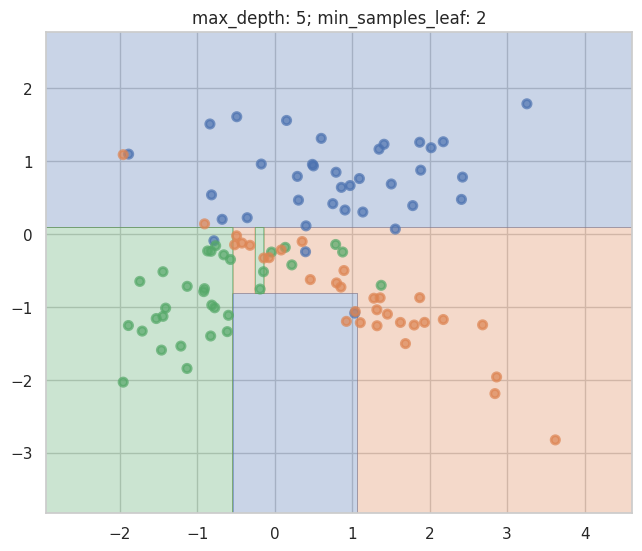

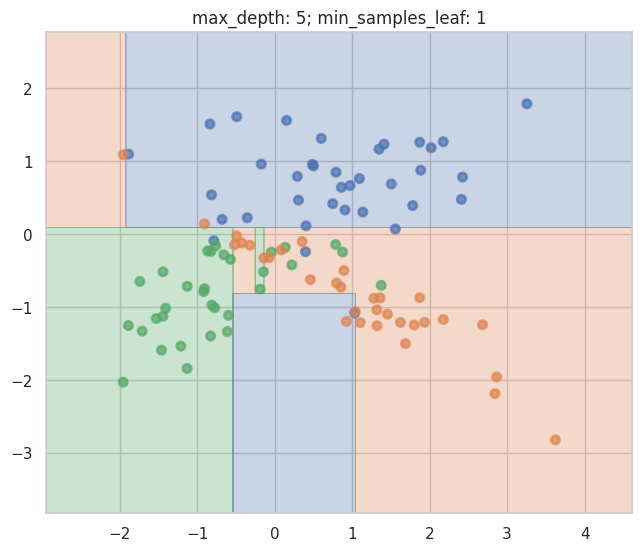

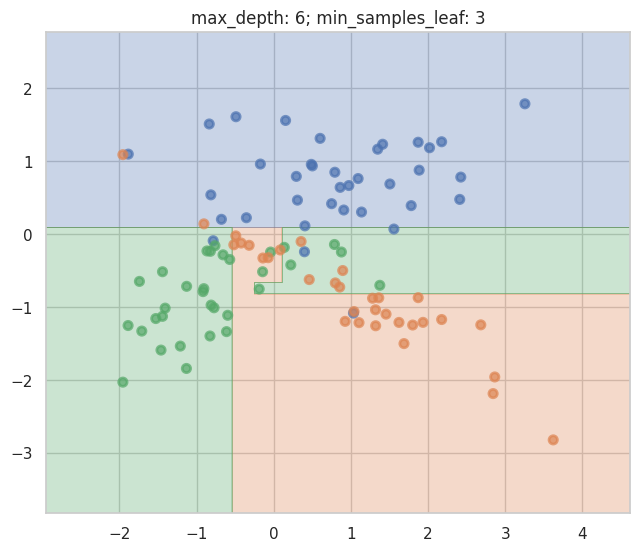

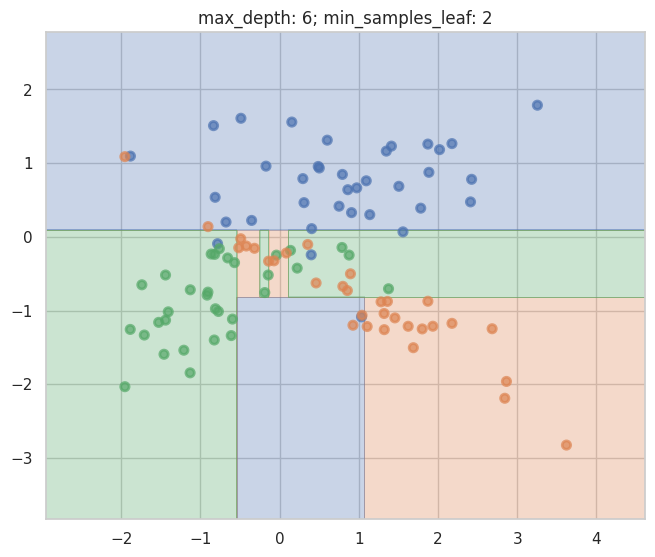

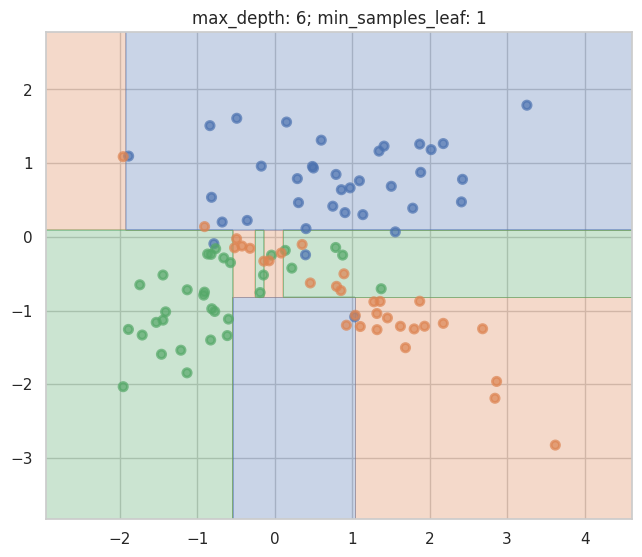

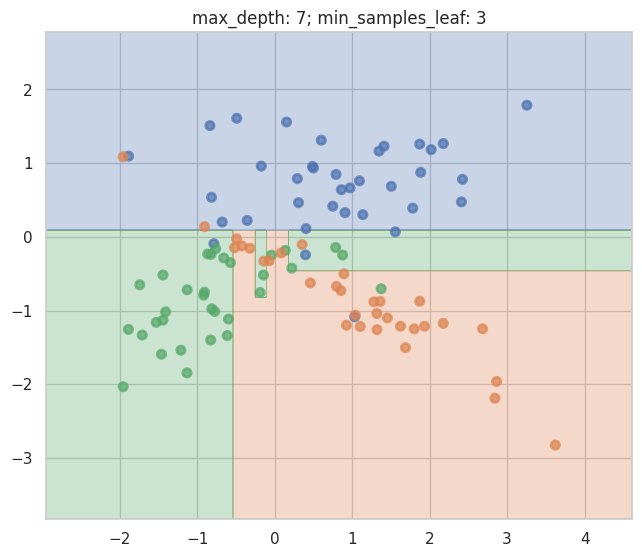

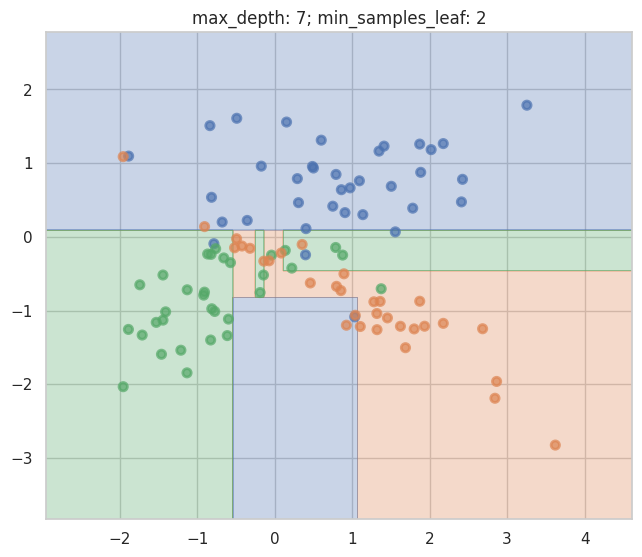

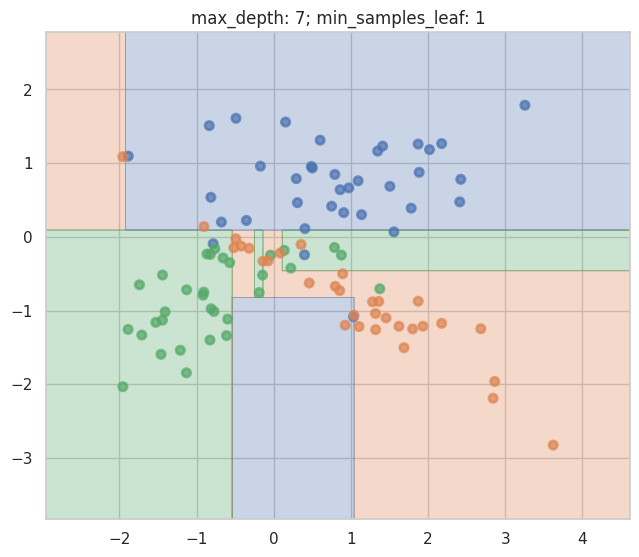

In [12]:
X, y = datasets[2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
boo()

__Ответ:__ Заметим, что чем больше max_depth дерева и чем меньше min_samples_leaf, то тем больше мы переобучаемся (то есть качество на треине значительно больше качества на тесте). Последние графики в каждом из датасетов такие же, как и из 1 задания, то есть мы видим можем наблюдать переобучение. Также по табличке с accuracy это тоже видно: если зафиксировать некоторую max_depth и прокрутить все возможные значения min_samples_leaf, то для min_samples_leaf == 1 получим наибольший разрыв между качеством на треине и тесте. Ну и аналогично этот разрыв увеличивается с ростом max_depth, если мы зафиксируем некоторый min_samples_leaf.

Переобучение происходит из-за того, что чем больше мы разрешаем дереву быть максимально глубоким, тем лучше он будет "подстраиваться" под обучающую выборку и выдавать высокий accuracy на нем. И если мы ставим минимально возможный min_samples_leaf, то мы можем получить такую ситуацию, что в каждом листе будет по одной вершине, и опять же accuracy на треине будет 1 и будет переобучение.

---



# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw5code.py

Под критерием Джини здесь подразумевается следующая функция:
$$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$,
$R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево, $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.

**Если что вот успешная посылка:** https://contest.yandex.ru/contest/56884/run-report/102713561/

**Ник в контесте:** 	rrgolovachev@edu.hse.ru

**И еще вот сам код:**

In [13]:
import numpy as np
from collections import Counter


def find_best_split(feature_vector, target_vector):
    """
    Под критерием Джини здесь подразумевается следующая функция:
    $$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$,
    $R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
     $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.

    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    sorted_target = target_vector[np.argsort(feature_vector)]
    sorted_features = np.sort(feature_vector)
    thresholds = (sorted_features[:-1] + sorted_features[1:]) / 2

    mask = np.isin(thresholds, feature_vector, invert=True)
    R_l = np.arange(1, sorted_target.shape[0])[mask]
    R_r = target_vector.shape[0] - R_l
    thresholds = thresholds[mask]


    p1_left = (np.cumsum(sorted_target[:-1]) / np.arange(1, sorted_target.shape[0]))[mask]
    p0_left = 1 - p1_left
    H_left = 1 - p1_left ** 2 - p0_left ** 2
    p1_right = (np.cumsum(sorted_target[-1:0:-1]) / np.arange(1, sorted_target.shape[0]))[::-1][mask]
    p0_right = 1 - p1_right
    H_right = 1 - p1_right ** 2 - p0_right ** 2
    R = target_vector.shape[0]

    ginis = - (R_l / R) * H_left - (R_r / R) * H_right
    threshold_best = thresholds[np.argmax(ginis)]
    gini_best = np.max(ginis)
    return thresholds, ginis, threshold_best, gini_best


class DecisionTree:
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(self, sub_X, sub_y, node):
        if np.all(sub_y != sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(1, sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])
                clicks = Counter(sub_X[sub_y == 1, feature])
                ratio = {}
                for key, current_count in counts.items():
                    if key in clicks:
                        current_click = clicks[key]
                    else:
                        current_click = 0
                    ratio[key] = current_count / current_click
                sorted_categories = list(map(lambda x: x[1], sorted(ratio.items(), key=lambda x: x[1])))
                categories_map = dict(zip(sorted_categories, list(range(len(sorted_categories)))))

                feature_vector = np.array(map(lambda x: categories_map[x], sub_X[:, feature]))
            else:
                raise ValueError

            if len(feature_vector) == 3:
                continue

            _, _, threshold, gini = find_best_split(feature_vector, sub_y)
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini
                split = feature_vector < threshold

                if feature_type == "real":
                    threshold_best = threshold
                elif feature_type == "Categorical":
                    threshold_best = list(map(lambda x: x[0],
                                              filter(lambda x: x[1] < threshold, categories_map.items())))
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
        else:
            raise ValueError
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[split], node["right_child"])

    def _predict_node(self, x, node):
        # ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        pass

    def fit(self, X, y):
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)


__Задание 4. (0.5 балла)__

Загрузите таблицу [students.csv](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/homeworks-practice/homework-practice-05-trees/students.csv) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [14]:
df = pd.read_csv('students.csv', sep=',')
df.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


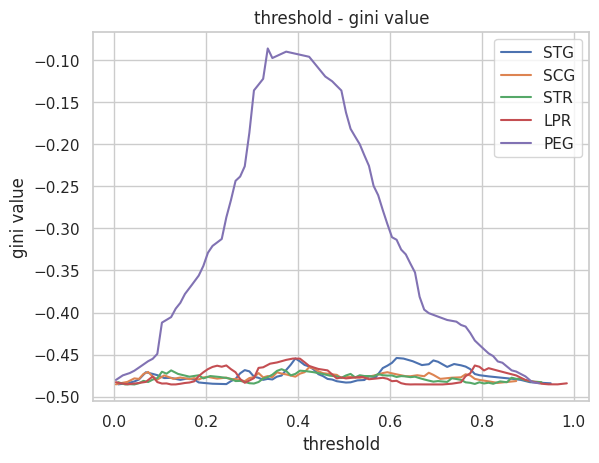

In [15]:
import seaborn as sns

X = df.drop('UNS', axis=1)
y = df['UNS']

plt.title('threshold - gini value')
plt.xlabel('threshold')
plt.ylabel('gini value')
for column in X.columns:
  thresholds, ginis, threshold_best, gini_best = find_best_split(np.array(X[column]), np.array(y))
  sns.lineplot(x=thresholds, y=ginis, label=column)

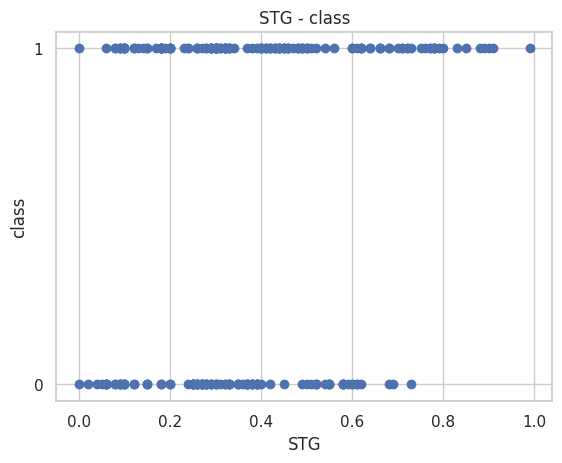

In [16]:
plt.yticks([0, 1])
plt.title('STG - class')
plt.xlabel('STG')
plt.ylabel('class')
plt.scatter(X['STG'], y)

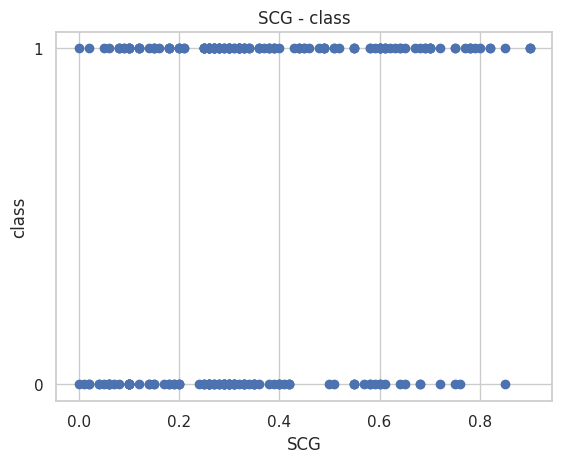

In [17]:
plt.yticks([0, 1])
plt.title('SCG - class')
plt.xlabel('SCG')
plt.ylabel('class')
plt.scatter(X['SCG'], y)

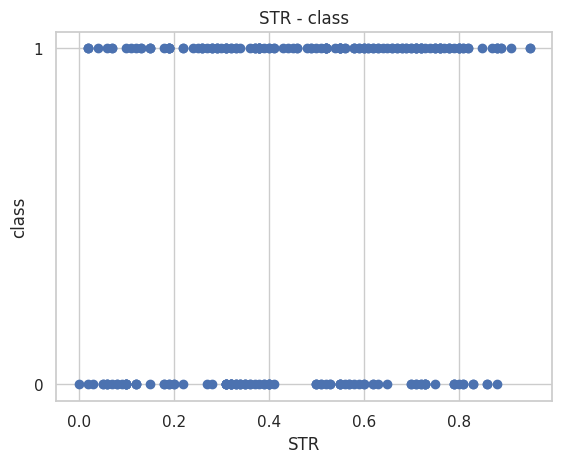

In [18]:
plt.yticks([0, 1])
plt.title('STR - class')
plt.xlabel('STR')
plt.ylabel('class')
plt.scatter(X['STR'], y)

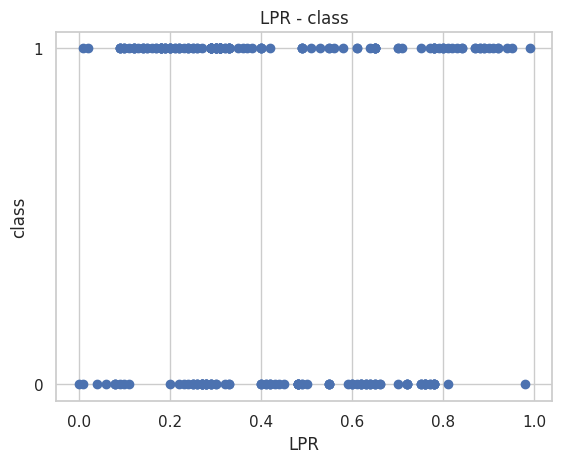

In [19]:
plt.yticks([0, 1])
plt.title('LPR - class')
plt.xlabel('LPR')
plt.ylabel('class')
plt.scatter(X['LPR'], y)

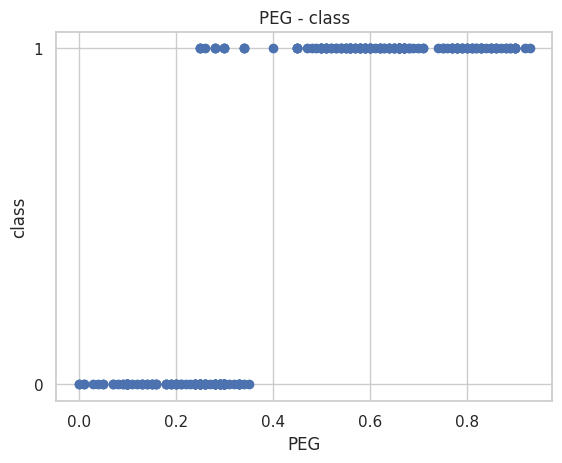

In [20]:
plt.yticks([0, 1])
plt.title('PEG - class')
plt.xlabel('PEG')
plt.ylabel('class')
plt.scatter(X['PEG'], y)

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** PEG самый полезный признак, на самом первом графике видно, что подбирая трешхолд можно получить относительно высокий коэфицент джини на этом признаке, тогда как остальные графики слабо колеблются где то на дне. На scatter графике это тоже отчетливо видно: можно прочертить вертикальную прямую, довольно хорошо отделяющую один класс от другого. Идеальная кривая для "хороших" признаков выглядит примерно так: мы ~монотонно возрастаем, достигаем пика, а затем также убываем. Кривые для признаков, по которым делить практически невозможно выглядят просто как рандомный шум и сложно выделить некоторый "пик" на таком графике

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw5code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

 **Ссылка на посылку:** https://contest.yandex.ru/contest/56884/run-report/102749323/

 **Ник в контесте:** rrgolovachev@edu.hse.ru

In [21]:
import numpy as np
import sys
from collections import Counter


def find_best_split(feature_vector, target_vector):
    """
    Под критерием Джини здесь подразумевается следующая функция:
    $$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r)$$,
    $R$ — множество объектов, $R_l$ и $R_r$ — объекты, попавшие в левое и правое поддерево,
     $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ — доля объектов класса 1 и 0 соответственно.

    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    sorted_target = target_vector[np.argsort(feature_vector)]
    sorted_features = np.sort(feature_vector)
    thresholds = (sorted_features[:-1] + sorted_features[1:]) / 2

    mask = np.isin(thresholds, feature_vector, invert=True)
    thresholds = thresholds[mask]
    R_l = np.arange(1, sorted_target.shape[0])[mask]
    R_r = target_vector.shape[0] - R_l


    p1_left = (np.cumsum(sorted_target[:-1]) / np.arange(1, sorted_target.shape[0]))[mask]
    p0_left = 1 - p1_left
    H_left = 1 - p1_left ** 2 - p0_left ** 2
    p1_right = (np.cumsum(sorted_target[-1:0:-1]) / np.arange(1, sorted_target.shape[0]))[::-1][mask]
    p0_right = 1 - p1_right
    H_right = 1 - p1_right ** 2 - p0_right ** 2
    R = target_vector.shape[0]

    ginis = - (R_l / R) * H_left - (R_r / R) * H_right
    threshold_best = thresholds[np.argmax(ginis)]
    gini_best = np.max(ginis)
    return thresholds, ginis, threshold_best, gini_best


class DecisionTree:
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        self._tree = {"depth": 0}
        self._feature_types = feature_types
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf

    def _fit_node(self, sub_X, sub_y, node):
        if self._max_depth == node["depth"] or (self._min_samples_split != None and self._min_samples_split > sub_X.shape[0]):
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                counts = Counter(sub_X[:, feature])
                clicks = Counter(sub_X[sub_y == 1, feature])
                ratio = {}
                for key, current_count in counts.items():
                    if key in clicks:
                        current_click = clicks[key]
                    else:
                        current_click = 0
                    ratio[key] = current_click / current_count
                sorted_categories = list(map(lambda x: x[0], sorted(ratio.items(), key=lambda x: x[1])))
                categories_map = dict(zip(sorted_categories, list(range(len(sorted_categories)))))

                feature_vector = np.array(list(map(lambda x: categories_map[x], sub_X[:, feature])))
            else:
                raise ValueError

            if np.unique(feature_vector).shape[0] == 1:
                continue

            _, _, threshold, gini = find_best_split(feature_vector, sub_y)
            left_cnt = np.sum(feature_vector < threshold)
            right_cnt = feature_vector.shape[0] - left_cnt
            if (gini_best is None or gini > gini_best) and (self._min_samples_leaf is None or min(left_cnt, right_cnt) >= self._min_samples_leaf):
                feature_best = feature
                gini_best = gini
                split = feature_vector < threshold

                if feature_type == "real":
                    threshold_best = threshold
                elif feature_type == "categorical":
                    threshold_best = list(map(lambda x: x[0],
                                              filter(lambda x: x[1] < threshold, categories_map.items())))
                else:
                    raise ValueError

        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_best"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["categories_split"] = threshold_best
        else:
            raise ValueError
        node["left_child"], node["right_child"] = {"depth": node["depth"] + 1}, {"depth": node["depth"] + 1}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x, node):
        if node["type"] == "terminal":
            return node["class"]
        feature_best = node["feature_best"]
        if self._feature_types[feature_best] == "real":
            threshold_best = node["threshold"]
            if x[feature_best] < threshold_best:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif self._feature_types[feature_best] == "categorical":
            categories_split = node["categories_split"]
            if x[feature_best] in categories_split:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError

    def get_params(self, deep):
        return {'feature_types': self._feature_types,
                'max_depth': self._max_depth,
                'min_samples_split': self._min_samples_split,
                'min_samples_leaf': self._min_samples_leaf}

    def fit(self, X, y):
        self._fit_node(X, y, self._tree)

    def predict(self, X):
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
        return np.array(predicted)

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [22]:
!pip install gitpython

import git
import shutil

# Клонируем репозиторий
git.Repo.clone_from('https://github.com/esokolov/ml-course-hse.git', 'datasets')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00


<git.repo.base.Repo '/content/datasets/.git'>

In [23]:
shutil.copy('datasets/2023-fall/homeworks-practice/homework-practice-05-trees/agaricus-lepiota.data', 'agaricus-lepiota.data')

'agaricus-lepiota.data'

In [24]:
import numpy as np
import pandas as pd

# он тут распарсил первый объект как названия столбцов, но я надеюсь это не страшно
df = pd.read_table('agaricus-lepiota.data', sep=',')
df

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8119,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8120,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8121,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [25]:
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:, 1:]
y = df.iloc[:, 0]
enc = LabelEncoder()
for column in X.columns:
  X[column] = enc.fit_transform(X[column])
y = enc.fit_transform(y)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [27]:
from sklearn.metrics import accuracy_score
clf = DecisionTree(['categorical'] * X.columns.shape[0])
clf.fit(np.array(X_train), np.array(y_train))
print(accuracy_score(y_test, clf.predict(np.array(X_test))))

1.0


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

**Ответ:** графики будут в конце, если что. В коде в задании 6 я поддержал эти параметры.

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [28]:
shutil.copy('datasets/2023-fall/homeworks-practice/homework-practice-05-trees/tic-tac-toe-endgame.csv', 'tic-tac-toe-endgame.csv')

'tic-tac-toe-endgame.csv'

In [29]:
!wget https://archive.ics.uci.edu/static/public/19/car+evaluation.zip
!unzip car+evaluation.zip

--2023-12-14 19:03:21--  https://archive.ics.uci.edu/static/public/19/car+evaluation.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘car+evaluation.zip’

car+evaluation.zip      [ <=>                ]   6.19K  --.-KB/s    in 0s      

2023-12-14 19:03:22 (90.1 MB/s) - ‘car+evaluation.zip’ saved [6342]

Archive:  car+evaluation.zip
  inflating: car.c45-names           
  inflating: car.data                
  inflating: car.names               


In [30]:
!wget https://archive.ics.uci.edu/static/public/76/nursery.zip
!unzip nursery.zip

--2023-12-14 19:03:22--  https://archive.ics.uci.edu/static/public/76/nursery.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘nursery.zip’

nursery.zip             [ <=>                ]  41.70K  --.-KB/s    in 0.08s   

2023-12-14 19:03:22 (492 KB/s) - ‘nursery.zip’ saved [42703]

Archive:  nursery.zip
  inflating: nursery.c45-names       
  inflating: nursery.data            
  inflating: nursery.names           


In [31]:
df_tictac = pd.read_csv('tic-tac-toe-endgame.csv')
df_tictac

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive
...,...,...,...,...,...,...,...,...,...,...
953,o,x,x,x,o,o,o,x,x,negative
954,o,x,o,x,x,o,x,o,x,negative
955,o,x,o,x,o,x,x,o,x,negative
956,o,x,o,o,x,x,x,o,x,negative


In [32]:
df_cars = pd.read_table('car.data', sep=',')
df_cars

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,vhigh,vhigh,2,2,small,med,unacc
1,vhigh,vhigh,2,2,small,high,unacc
2,vhigh,vhigh,2,2,med,low,unacc
3,vhigh,vhigh,2,2,med,med,unacc
4,vhigh,vhigh,2,2,med,high,unacc
...,...,...,...,...,...,...,...
1722,low,low,5more,more,med,med,good
1723,low,low,5more,more,med,high,vgood
1724,low,low,5more,more,big,low,unacc
1725,low,low,5more,more,big,med,good


In [33]:
df_nursery = pd.read_table('nursery.data', sep=',')
df_nursery

,usual,proper,complete,1,convenient,convenient.1,nonprob,recommended,recommend
0,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
1,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
2,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
3,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
4,usual,proper,complete,1,convenient,convenient,slightly_prob,not_recom,not_recom
...,...,...,...,...,...,...,...,...,...
12954,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12956,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [34]:
df_mushrooms = df

In [35]:
dataset_index = 0
for cur_df in [df_mushrooms, df_tictac, df_cars, df_nursery]:
  enc = LabelEncoder()
  column_index = 0
  for column in cur_df.columns:
    if column_index == cur_df.shape[1] - 1 and dataset_index == 2:
      cur_df[column] = cur_df.apply(lambda row: 0 if row.iloc[-1] == 'acc' or row.iloc[-1] == 'unacc' else 1, axis=1)
      continue
    if column_index == cur_df.shape[1] - 1 and dataset_index == 3:
      cur_df[column] = cur_df.apply(lambda row: 0 if row.iloc[-1] == "not_recom" or row.iloc[-1] == "recommend" else 1, axis=1)
      continue
    cur_df[column] = enc.fit_transform(cur_df[column])
    column_index += 1
  dataset_index += 1

In [36]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

result = pd.DataFrame(columns=['DecisionTree real', 'DecisionTree categorical', 'DecisionTree real + ohe', 'DecisionTreeClassifier'],
                      index=['mushrooms', 'tictac', 'cars', 'nursery'])
for clf_index in range(4):
  df_index = 0
  scores = []
  for cur_df_ in [df_mushrooms, df_tictac, df_cars, df_nursery]:
    cur_df = cur_df_.copy()
    cur_df = cur_df.sample(frac=1).reset_index(drop=True) # do random shuffle
    if df_index == 0:
      X = cur_df.iloc[:, 1:]
      y = cur_df.iloc[:, 0]
    else:
      X = cur_df.iloc[:, :-1]
      y = cur_df.iloc[:, -1]

    if clf_index == 0:
      clf = DecisionTree(['real'] * X.columns.shape[0])
    elif clf_index == 1:
      clf = DecisionTree(['categorical'] * X.columns.shape[0])
    elif clf_index == 2:
      ohe = OneHotEncoder(sparse=False)
      X = ohe.fit_transform(X)
      clf = DecisionTree(['real'] * X.shape[0])
    else:
      clf = DecisionTreeClassifier()

    score = np.mean(cross_val_score(clf, np.array(X), np.array(y), scoring=make_scorer(accuracy_score), cv=10))
    scores.append(score)
    df_index += 1
  result.iloc[:, clf_index] = scores
result

,DecisionTree real,DecisionTree categorical,DecisionTree real + ohe,DecisionTreeClassifier
mushrooms,1.000000,1.000000,1.000000,1.000000
tictac,0.875779,0.950976,0.950899,0.885121
cars,0.991313,0.994791,0.988423,0.990748
nursery,0.999691,0.999691,0.999614,0.999691


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:** Нет, неодинаково (например, для tictac DecisionTree real + ohe будет лучше чем решающее дерево из sklearn, а в cars ситуация противоположная). Попытаюсь объяснить, почему на мой взгляд в случае tic-tac toe DecisionTree real + ohe будет работать лучше чем DecisionTreeClassifier. В DecisionTreeClassifier мы используем данные, закодированные с помощью NaturalEncoding и у нас в `find_best_split` будет два трешхолда (ну чаще всего): 0.5 и 1.5 (так как крестик, нолик и пустое поле перешли в числа от 0 до 2). И если одно состояние закодировано как 0, а другое как 2, то два объекта (в нашем случае - запись игры) никак не попадут в одну часть дерева (всегда один будет идти налево, а другой - направо). И это довольно странное ограничение. В случае OneHotEncoding такого ограничения нет, трешхолд у нас один и мы по сути дела ищем только наилучший признак для сравнения. То есть мы сразу выбираем клетку + состояние в ней и смотрим, насколько хорошо получилось разделить. Довольно логичное решение для предсказания игры в крестики-нолики.

В случае датасета cars evaluation у нас появляется некое отношение порядка на значениях признака и OneHotEncoder это никак не учитывает. NaturalEncoding же может уважить порядок, а может и нет) Тут как повезет и зависит от того, как NaturalEncoding раздаст чиселки нашим категориальным признакам. Вот если например признак buying (у меня кривой датафрейм, и там названия столбцов не те, так что я ориентируюсь на описание с https://archive.ics.uci.edu/dataset/19/car+evaluation) будет закодирован как vhigh - 3, high - 2, med - 1, low - 0, то получим результат лучше, чем с OHE.

В результатах (чиселках из финальной таблички) безусловно присутствует компонента случайности. До того, как я рандомно пошафлил объекты из выборки, качество на tic tac toe было относительно низким (0.76 на DecisionTreeClassifier). После шаффла стало 0.87, а это неплохой буст. Дело было в том, что в том датасете сначала идут все positive исходы, а потом все negative. Ну и в целом после шафла везде улучшился результат, так как объекты идут очень "неравномерно" в оригинальном датасете.

**РЕШЕНИЕ БОНУСА:**

Задание 8. (бонус, 1 балл)

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

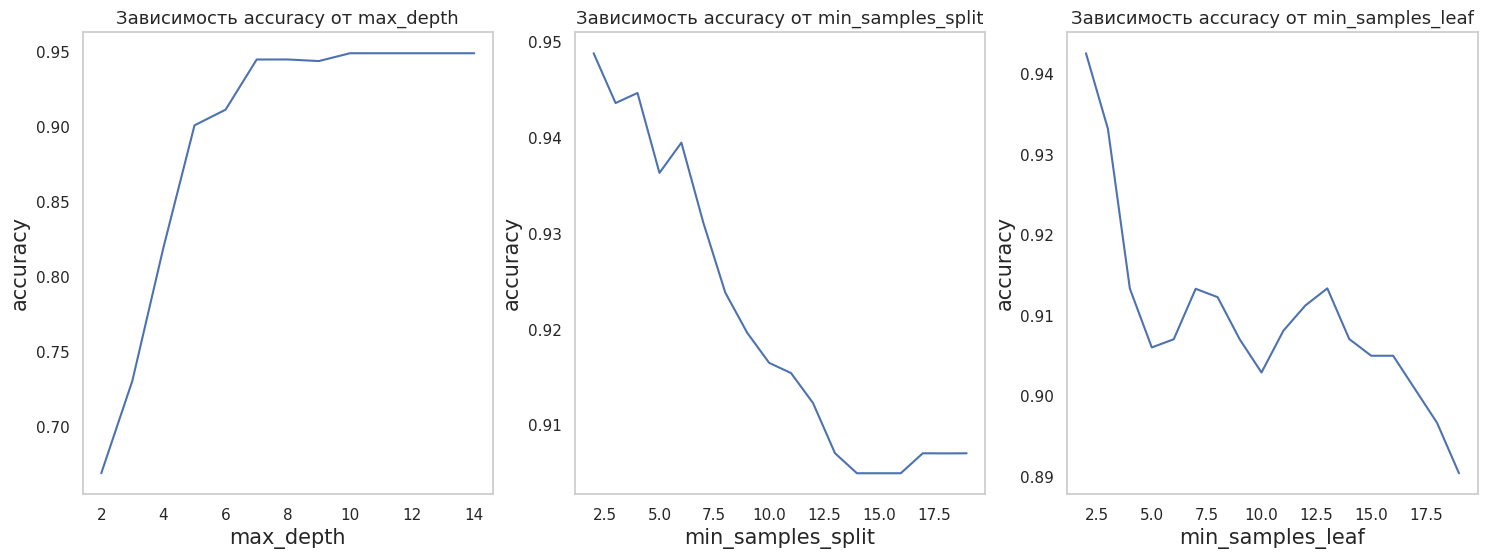

In [37]:
cur_df = df_tictac.copy()
cur_df = cur_df.sample(frac=1).reset_index(drop=True) # do random shuffle

X = cur_df.iloc[:, :-1]
y = cur_df.iloc[:, -1]

scores_max_depth = []
scores_min_samples_split = []
scores_min_samples_leaf = []
for max_depth in range(2, 15):
  clf = DecisionTree(['categorical'] * X.columns.shape[0], max_depth=max_depth)
  score = np.mean(cross_val_score(clf, np.array(X), np.array(y), scoring=make_scorer(accuracy_score), cv=10))
  scores_max_depth.append(score)

for min_samples_split in range(2, 20):
  clf = DecisionTree(['categorical'] * X.columns.shape[0], min_samples_split=min_samples_split)
  score = np.mean(cross_val_score(clf, np.array(X), np.array(y), scoring=make_scorer(accuracy_score), cv=10))
  scores_min_samples_split.append(score)

for min_samples_leaf in range(2, 20):
  clf = DecisionTree(['categorical'] * X.columns.shape[0], min_samples_leaf=min_samples_leaf)
  score = np.mean(cross_val_score(clf, np.array(X), np.array(y), scoring=make_scorer(accuracy_score), cv=10))
  scores_min_samples_leaf.append(score)

plt.figure(figsize = (18, 6))

plt.subplot(1, 3, 1)
plt.plot(np.arange(2, 15), scores_max_depth)
plt.title('Зависимость accuracy от max_depth', fontsize=13)
plt.xlabel('max_depth', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.grid()


plt.subplot(1, 3, 2)
plt.plot(np.arange(2, 20), scores_min_samples_split)
plt.title('Зависимость accuracy от min_samples_split', fontsize=13)
plt.xlabel('min_samples_split', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(np.arange(2, 20), scores_min_samples_leaf)
plt.title('Зависимость accuracy от min_samples_leaf', fontsize=13)
plt.xlabel('min_samples_leaf', fontsize=15)
plt.ylabel('accuracy', fontsize=15)
plt.grid()

plt.show()

Вставьте что угодно, описывающее ваши впечатления от этого задания:

Самая приятная из всех дз, особенно после того как тесты открыли. Правда сдаю все равно с опозданием ;( Но в этот раз заюзаю просрочку без штрафа